In [1]:
# Simple simulation of metastasis to test the assumptions of the met-score metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import sklearn.metrics as sklm

In [3]:
def iterate_doublings(cells, alpha):
    new_cells = []
    for cell in cells:
        new_cells.append(cell)
        if np.random.random() < alpha: # cell divides!
            new_cells.append(cell)
    return new_cells

def iterate_extinction(cells, beta):
    new_cells = []
    for cell in cells:
        if (np.random.random() > beta) or (len(cells)<=10): # cell survives!
            new_cells.append(cell)
    return new_cells

def iterate_metastasis(cells, mu, n_mets):
    new_cells = []
    for cell in cells:
        if np.random.random() >= mu: 
            new_cells.append(cell)
        else:
            temp_sample_list = sample_list.copy()
            temp_sample_list.remove(cell)
            new_sample = np.random.choice(temp_sample_list) # cell metastasizes!
            new_cells.append(new_sample)
            n_mets+=1
    return new_cells, n_mets

In [4]:
# define parameters:
N_clones = 1000 #number of clones to simulate
max_mu = 0.3 #max rate of metastasis
min_alpha = 0.75 #min rate of doubling
t_range = [12,16] #range of time-steps
sigma = 6 #number of tumor samples
beta = 0.00 #extinction rate

# make samples
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
sample_list = [alphabet[i] for i in range(sigma)]

# generate color list
cmap = plt.cm.get_cmap('twilight_shifted')
cmap_list = []
for i in range(len(sample_list)):
    cmap_list.append(cmap(i/len(sample_list)))

In [5]:
# make a masterDF of results
columner1 = ['mu', 'alpha', 't', 'N', 'n_mets']
columner2 = [sample_list[i] for i in range(len(sample_list))]
masterDF = pd.DataFrame(columns=columner1+columner2)

for iteration in range(0,N_clones):
    
    cells_list = ['A']
    
    # choose parameters randomly:
    mu = max_mu*np.random.random() # probability of metastasis per time-step (between 0 and 0.3)
    alpha = min_alpha+((1-min_alpha)*np.random.random()) # probability that cell will double per time-step (between 0.75 and 1.0)
    t = np.random.randint(t_range[0],high=t_range[1]) # number of time-steps in simulation
    
    # run iterations
    n_mets = 0
    for timestep in range(0,t):
        cells_list = iterate_doublings(cells_list, alpha)
        if beta > 0: cells_list = iterate_extinction(cells_list, beta)
        if mu > 0: cells_list, n_mets = iterate_metastasis(cells_list, mu, n_mets)
    
    # count cells per sample
    counts = []
    for sample in sample_list:
        counts.append(cells_list.count(sample))
    
    # update master
    col_i1 = [mu, alpha, t, len(cells_list), n_mets]
    col_i2 = [counts[i] for i in range(len(counts))]
    masterDF.loc[len(masterDF), :] = col_i1+col_i2
        
# calculate the normalized met count
masterDF['Norm_mets'] = masterDF['n_mets'].div(masterDF['N'])
masterDF = masterDF.sort_values(['Norm_mets'], ascending=False).reset_index(drop=True)

# check master
masterDF.head()

,mu,alpha,t,N,n_mets,A,B,C,D,E,F,Norm_mets
0,0.298717,0.761067,12,894,647,171,142,170,142,125,144,0.723714
1,0.299772,0.755574,12,573,404,74,80,99,86,106,128,0.705061
2,0.294127,0.751277,14,3029,2101,487,480,499,471,568,524,0.693628
3,0.297429,0.772138,13,1233,850,177,223,224,206,225,178,0.689376
4,0.299672,0.811822,14,4374,2996,737,680,753,697,724,783,0.684957


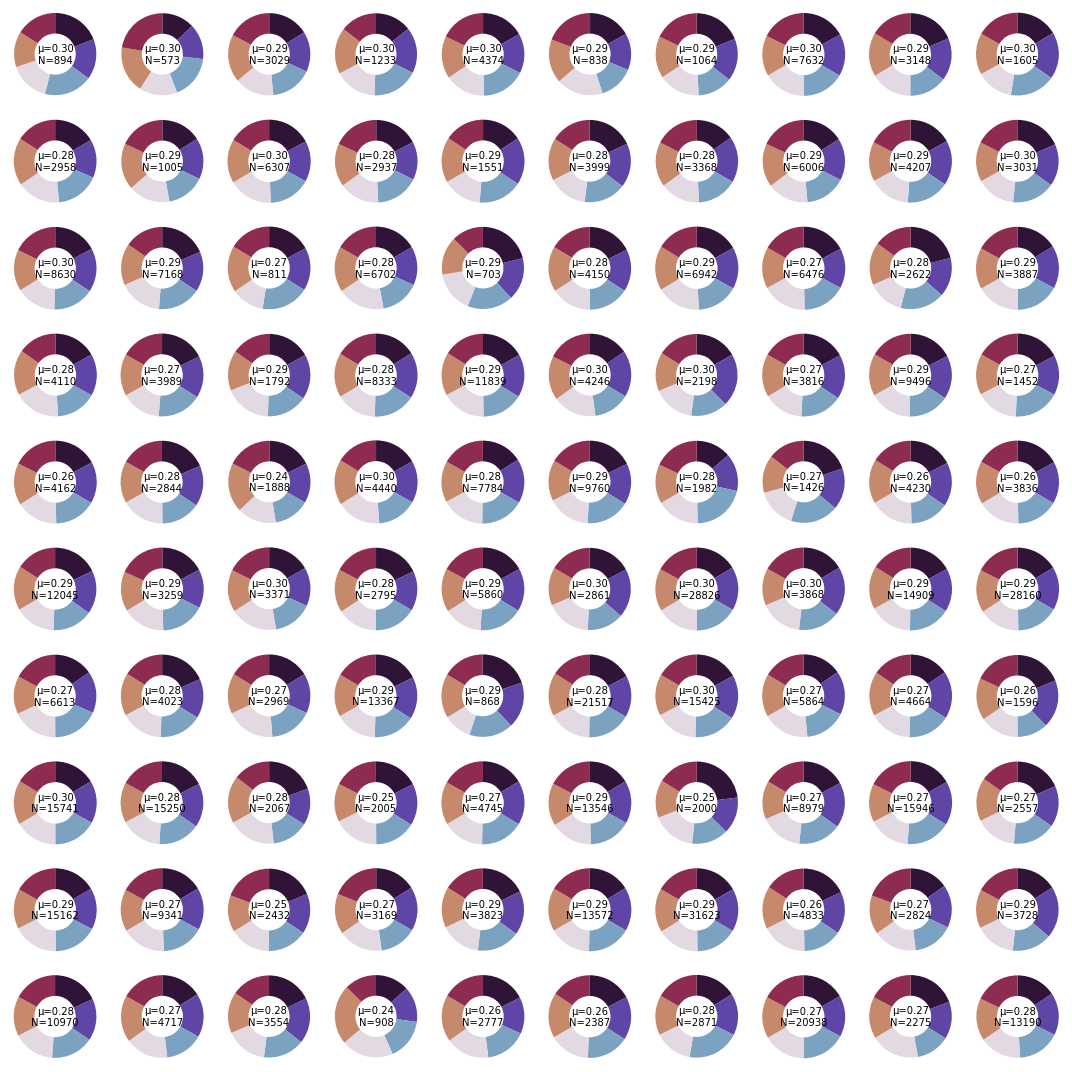

In [6]:
# Subplot distribution of UMI per cell per sample
f, axarr = plt.subplots(10, 10, figsize=(15,15))

for j in range(0,100):
    x = int((j)/10)
    y = int((j)%10)
    
    cellspersample = masterDF.iloc[j][sample_list].tolist()
    axarr[x,y].pie(cellspersample, colors=cmap_list, startangle=90, counterclock=False, wedgeprops=dict(width=0.5))
    axarr[x,y].text(0, 0, "µ="+"%.2f" % masterDF.iloc[j]['mu'] +"\nN="+str(masterDF.iloc[j]['N']), ha='center', va='center')
    axarr[x,y].axis('equal')
       
plt.tight_layout()

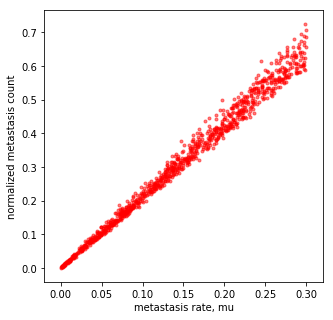

In [7]:
# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['Norm_mets'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('normalized metastasis count')

In [8]:
# Define Cramér's-V statistics functions

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [9]:
# Several issues:
# - how do you make a confusion matrix with different number of observations and expectations?
# - how do you calculate a Chi-sq when the expected is zero but observed is non-zero?

# find background distribution across all clones
pred = masterDF.filter(sample_list, axis=1).sum(axis=0)
pred_norm = pred.div(pred.sum())

cramers_list = []
for k in range(0,N_clones):
    
    # First, make an expanded list of the observed samples
    obs = masterDF.iloc[k][sample_list]
    obs_exp = []
    for i in range(len(obs)):
        for j in range(int(obs[i])):
            obs_exp.append(sample_list[i])
            
    # Next, make an expanded list of the expected samples (of the same dimension as the observed!?)  
    pred_exp = []
    progress = 0
    for i in range(len(obs)):
        progress += pred_norm[i]
        while float(len(pred_exp))/len(obs_exp) < progress:
            pred_exp.append(sample_list[i])
    
    # make confusion matrix of predicted vs observed
    confusion_matrix = sklm.confusion_matrix(obs_exp, pred_exp, labels=sample_list)
    
    # calculate Cramers V and update
    cramersV1 = cramers_corrected_stat(confusion_matrix)
    #cramersV2 = cramers_stat(confusion_matrix)
    cramers_list.append(cramersV1)

ValueError: The internally computed table of expected frequencies has a zero element at (3, 0).

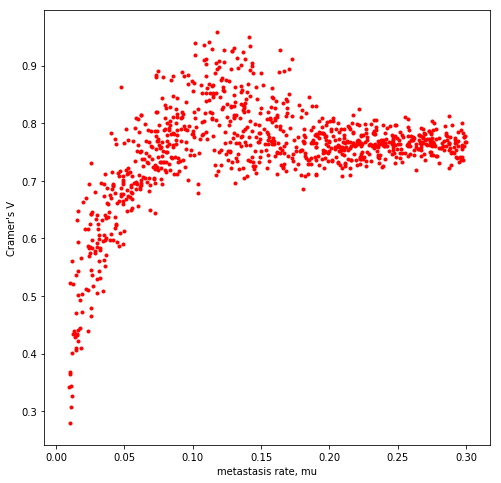

In [10]:
# plot distribution
h1 = plt.figure(1,figsize=(8,8))
scat = plt.scatter(masterDF.iloc[0:len(cramers_list)]['mu'], cramers_list, color='r', marker='.')
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel("Cramer's V")

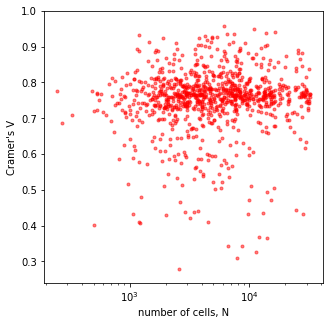

In [11]:
# plot correlation between number of cells and Cramers V
h2 = plt.figure(2,figsize=(5,5))
scat = plt.scatter(masterDF.iloc[0:len(cramers_list)]['N'], cramers_list, color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('number of cells, N')
ylab = plt.ylabel("Cramer's V")
xsca = plt.xscale("log")